In [23]:
# Install scipy and numpy
%pip install scipy numpy pandas matplotlib termcolor tabulate

Note: you may need to restart the kernel to use updated packages.


In [24]:
from scipy import stats
import pandas as pd

# Import necessary libraries
versions = ["22-04"]
cleanupType = ["shutdown", "terminate"]
systemd = ["sysd", "no"]
installed = ["yes", "no"]

In [25]:
def read_file(file: str):
    df = pd.read_csv(file)
    # Process data into dataframe, where each row is a trial.
    # Column 1 is ticks, column 2 is used memory. Parse from existing data into values

    # Take first column and get the values
    ticks = df.iloc[:, 0].values
    ticks = [int(x.split()[-1]) for x in ticks]

    # Take second column and get the values
    memory = df.iloc[:, 1].values
    memory = [int(x.split()[-1]) for x in memory]

    return pd.DataFrame(list(zip(ticks, memory)), columns=["Ticks", "Memory (KiB)"])

In [26]:
versions = ["Ubuntu-24.04", "Ubuntu-22.04", "Ubuntu-20.04"]

files = [
    # 24.04
    "pro-service/Ubuntu-24.04/ubuntu-24.04-terminate-sysd-yes.txt",
    "pro-service/Ubuntu-24.04/ubuntu-24.04-terminate-sysd-no.txt",
    "pro-service/Ubuntu-24.04/ubuntu-24.04-terminate-no-no.txt",
    "pro-service/Ubuntu-24.04/ubuntu-24.04-shutdown-sysd-yes.txt",
    "pro-service/Ubuntu-24.04/ubuntu-24.04-shutdown-sysd-no.txt",
    "pro-service/Ubuntu-24.04/ubuntu-24.04-shutdown-no-no.txt",
    #22.04
    "pro-service/Ubuntu-22.04/ubuntu-22.04-terminate-sysd-yes.txt",
    "pro-service/Ubuntu-22.04/ubuntu-22.04-terminate-sysd-no.txt",
    "pro-service/Ubuntu-22.04/ubuntu-22.04-terminate-no-no.txt",
    "pro-service/Ubuntu-22.04/ubuntu-22.04-shutdown-sysd-yes.txt",
    "pro-service/Ubuntu-22.04/ubuntu-22.04-shutdown-sysd-no.txt",
    "pro-service/Ubuntu-22.04/ubuntu-22.04-shutdown-no-no.txt",
    #20.04
    "pro-service/Ubuntu-20.04/ubuntu-20.04-terminate-sysd-no.txt",
    "pro-service/Ubuntu-20.04/ubuntu-20.04-terminate-no-no.txt",
    "pro-service/Ubuntu-20.04/ubuntu-20.04-shutdown-sysd-no.txt",
    "pro-service/Ubuntu-20.04/ubuntu-20.04-shutdown-no-no.txt",
]
data = {file.split("/", 1)[-1]: read_file(file) for file in files}

In [27]:
for file in data.keys():
    # Checking if normally distributed. (p-value > 0.05)
    print(f"File: {file}")
    print(data[file].keys())
    print(f"Ticks: {stats.shapiro(data[file]['Ticks'])}")
    print(f"Memory: {stats.shapiro(data[file]['Memory (KiB)'])}")

File: Ubuntu-24.04/ubuntu-24.04-terminate-sysd-yes.txt
Index(['Ticks', 'Memory (KiB)'], dtype='object')
Ticks: ShapiroResult(statistic=np.float64(0.9557262387408435), pvalue=np.float64(0.12818207321308006))
Memory: ShapiroResult(statistic=np.float64(0.8887194209877454), pvalue=np.float64(0.0010644220913095866))
File: Ubuntu-24.04/ubuntu-24.04-terminate-sysd-no.txt
Index(['Ticks', 'Memory (KiB)'], dtype='object')
Ticks: ShapiroResult(statistic=np.float64(0.9651703380024516), pvalue=np.float64(0.26405427293975686))
Memory: ShapiroResult(statistic=np.float64(0.9191857785869099), pvalue=np.float64(0.00820966979366214))
File: Ubuntu-24.04/ubuntu-24.04-terminate-no-no.txt
Index(['Ticks', 'Memory (KiB)'], dtype='object')
Ticks: ShapiroResult(statistic=np.float64(0.6225485766281174), pvalue=np.float64(8.599529137471305e-09))
Memory: ShapiroResult(statistic=np.float64(0.907328236716177), pvalue=np.float64(0.003603354169966365))
File: Ubuntu-24.04/ubuntu-24.04-shutdown-sysd-yes.txt
Index(['Ticks

Seems to be a mix between normally and non-normally distributed data. Can't make assumptions.
Data is collected from the same system under controlled circumstances, and can be assumed to be paired.


In [28]:
from tabulate import tabulate
from termcolor import colored

# Define the base version for comparison
base_version = "24.04"

# Prepare a list to store results for tabular display
results = []
for cleanup in cleanupType:
    for sysd in systemd:
        for install in installed:
            if install == "yes" and sysd == "no":
                continue
            base_file = f"Ubuntu-{base_version}/ubuntu-{base_version}-{cleanup}-{sysd}-{install}.txt"
            for version in versions:
                if version.split("-")[-1] == base_version:
                    continue  # Skip comparison with the base version itself
                compare_file = (
                    f"{version}/{version.lower()}-{cleanup}-{sysd}-{install}.txt"
                )
                if base_file in data and compare_file in data:
                    ticks_result = stats.wilcoxon(
                        data[base_file]["Ticks"], data[compare_file]["Ticks"]
                    )
                    memory_result = stats.wilcoxon(
                        data[base_file]["Memory (KiB)"],
                        data[compare_file]["Memory (KiB)"],
                    )
                    results.append(
                        [
                            colored(base_file.split("/")[-1], "cyan"),
                            colored(compare_file.split("/")[-1], "cyan"),
                            colored(
                                f"Ticks: {ticks_result}",
                                "green" if ticks_result.pvalue > 0.05 else "red",
                            ),
                            colored(
                                f"Memory: {memory_result}",
                                "green" if memory_result.pvalue > 0.05 else "red",
                            ),
                        ]
                    )
                else:
                    results.append(
                        [
                            colored(base_file.split("/")[-1], "cyan"),
                            colored(compare_file.split("/")[-1], "cyan"),
                            colored("Data missing", "yellow"),
                            colored("Data missing", "yellow"),
                        ]
                    )

# Print the results in a tabular format
headers = ["Base File", "Compare File", "Ticks Result", "Memory Result"]
print(tabulate(results, headers=headers, tablefmt="grid"))

+-------------------------------------+-------------------------------------+----------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------+
| Base File                           | Compare File                        | Ticks Result                                                                                 | Memory Result                                                                               |
+=====================================+=====================================+==============================================================================================+=============================================================================================+
| ubuntu-24.04-shutdown-sysd-yes.txt  | ubuntu-22.04-shutdown-sysd-yes.txt  | Ticks: WilcoxonResult(statistic=np.float64(3.0), pvalue=np.float64(1.8189894035458565e-11))  | Memory: WilcoxonResult(sta

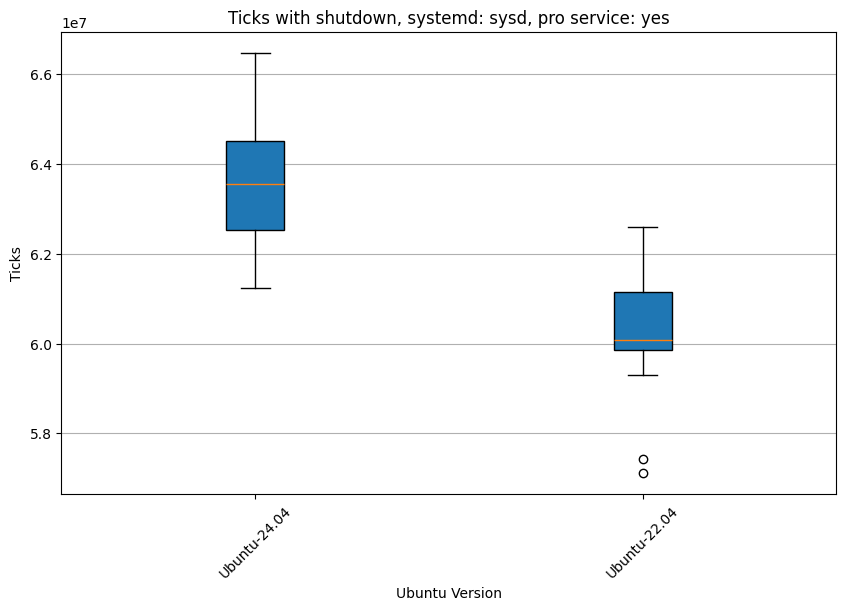

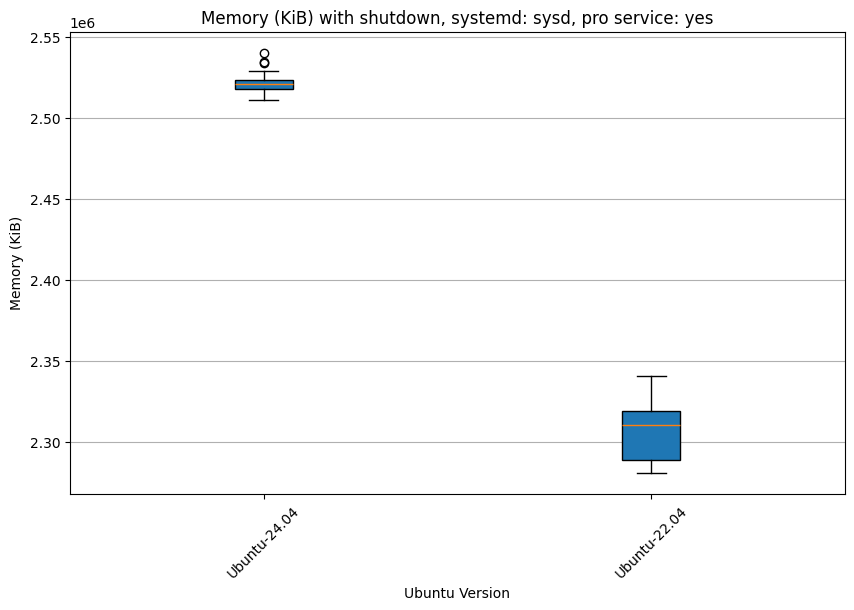

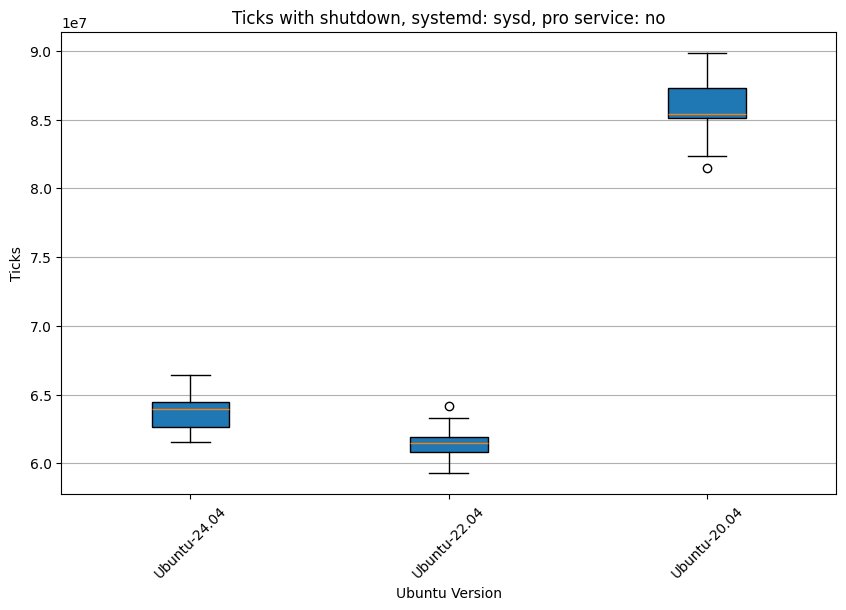

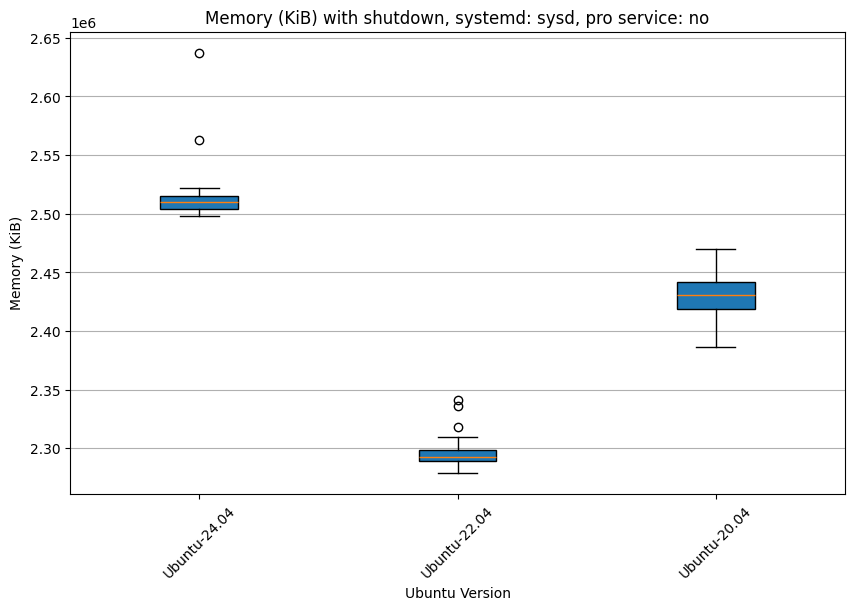

No Data for shutdown, Ticks, no, yes
No Data for shutdown, Memory (KiB), no, yes


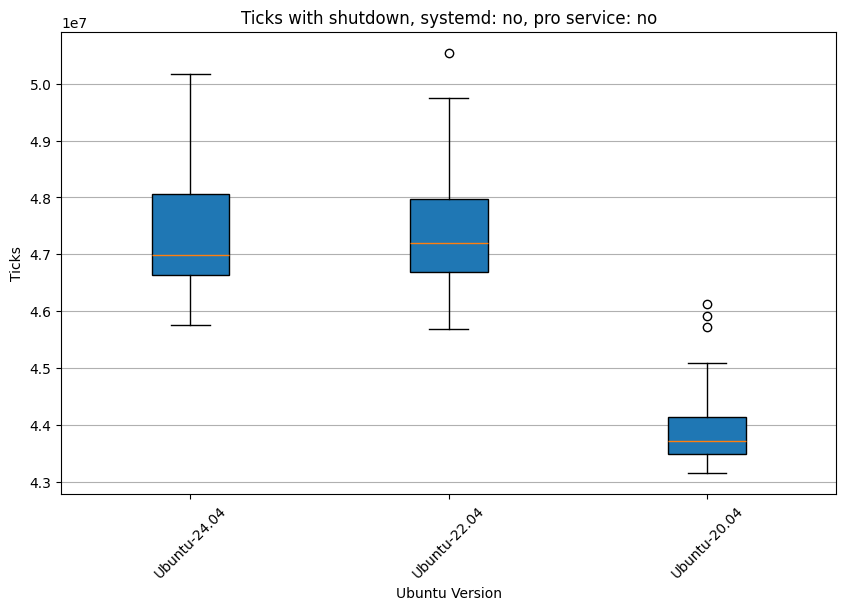

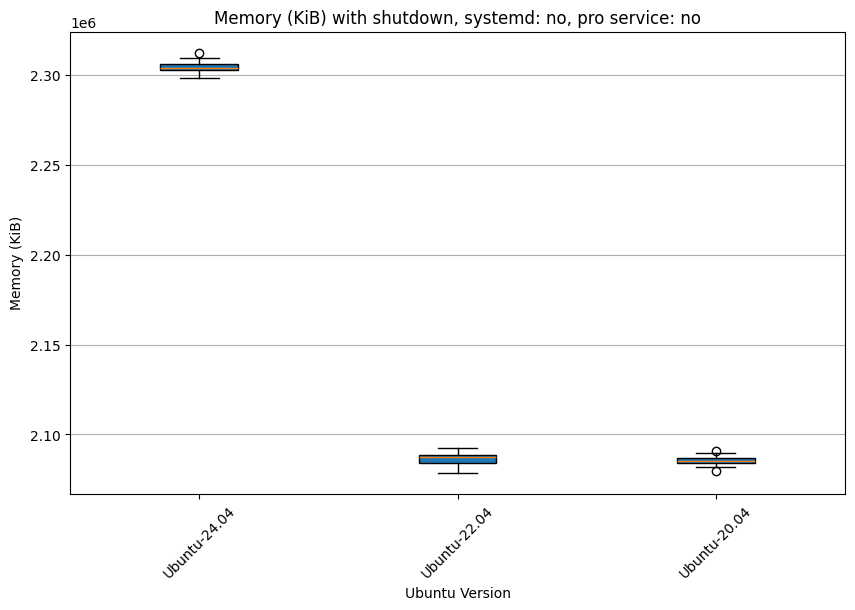

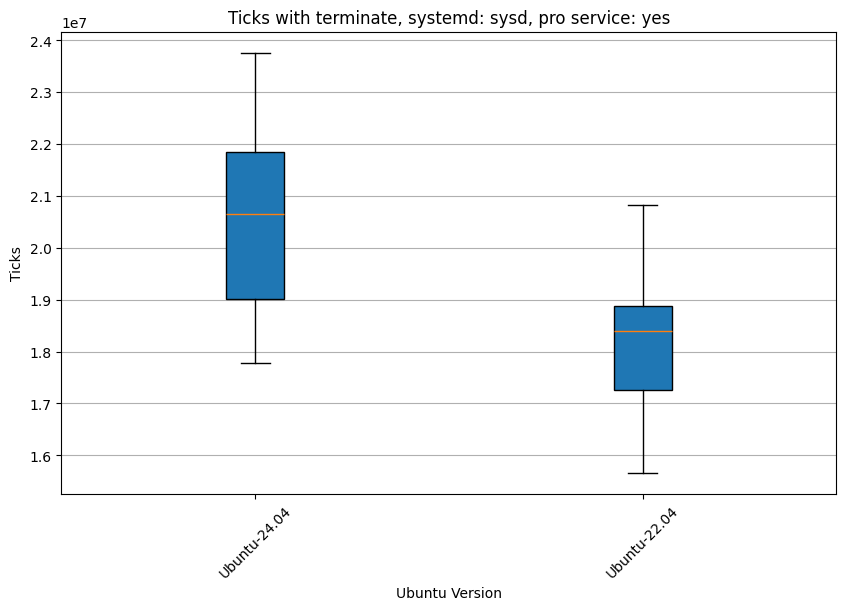

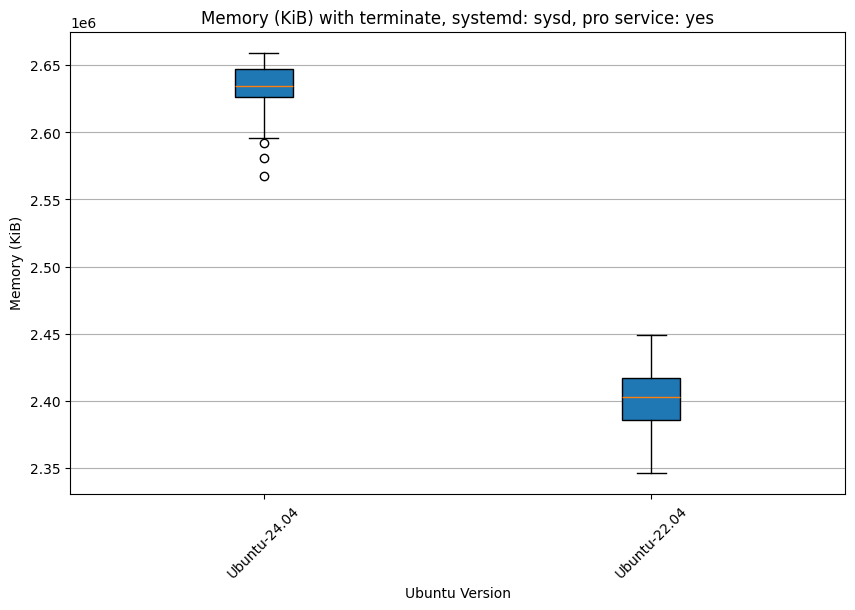

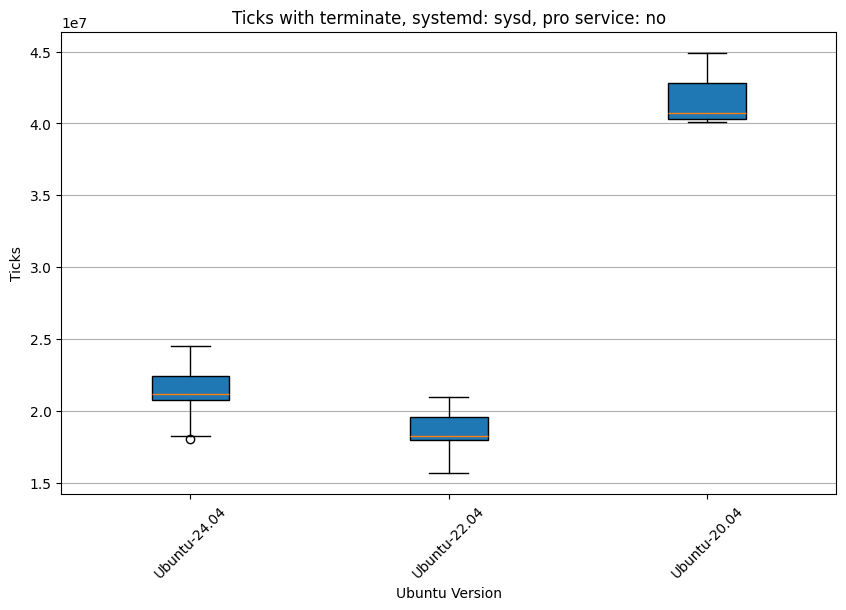

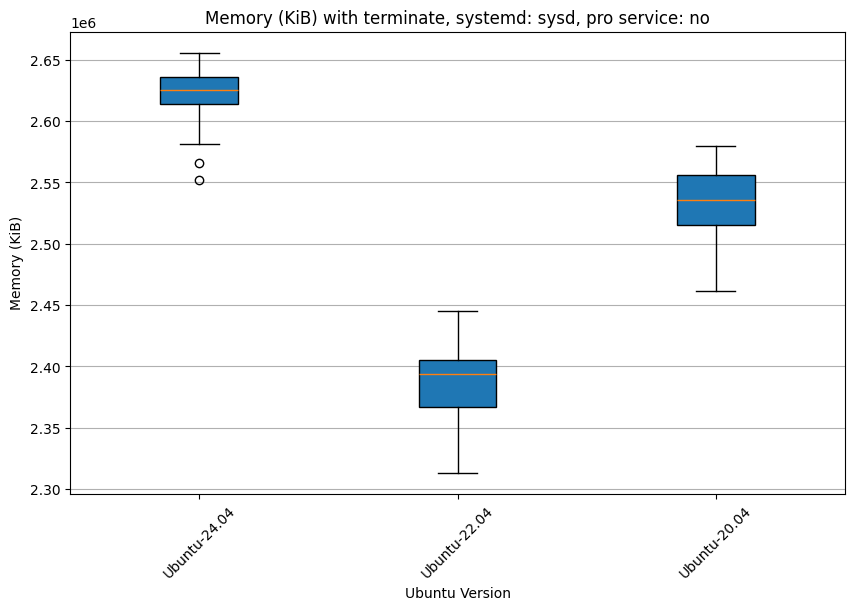

No Data for terminate, Ticks, no, yes
No Data for terminate, Memory (KiB), no, yes


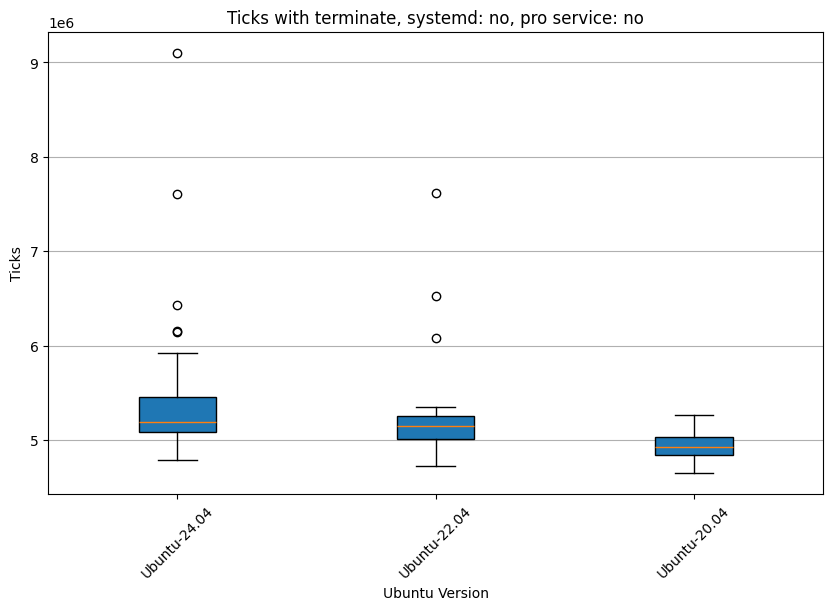

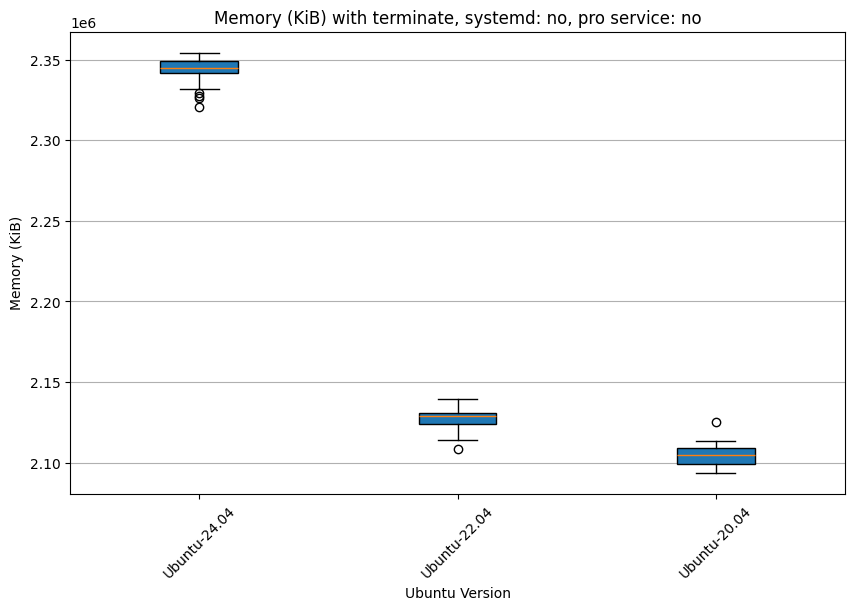

In [29]:
import matplotlib.pyplot as plt


# Function to generate box plots for a specific case
def plot_specific_case(close_method, metric, sysd, installed):
    case_data = []
    labels = []
    for version in ["24.04", "22.04", "20.04"]:
        file_name = (
            f"Ubuntu-{version}/ubuntu-{version}-{close_method}-{sysd}-{installed}.txt"
        )
        if file_name in data:
            case_data.append(data[file_name][metric])
            labels.append(f"Ubuntu-{version}")

    if len(labels) == 0:
        print(f"No Data for {close_method}, {metric}, {sysd}, {installed}")
        return
    plt.figure(figsize=(10, 6))
    plt.boxplot(case_data, tick_labels=labels, patch_artist=True)
    plt.title(
        f"{metric} with {close_method}, systemd: {sysd}, pro service: {installed}"
    )
    plt.ylabel(metric)
    plt.xlabel("Ubuntu Version")
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.show()


for close_method in cleanupType:
    for sysd in systemd:
        for i in installed:
            plot_specific_case(close_method, "Ticks", sysd, i)
            plot_specific_case(close_method, "Memory (KiB)", sysd, i)
